# Investigating the impact of moderator interventions

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
sns.set(style="whitegrid")
sns.set(font_scale=1.5)

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57470,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57471,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57472,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57473,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Fac. Guidelines,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


## When do moderators intervene?

In [5]:
df_unique = full_df[full_df["conv_variant"] != "No Moderator"].drop_duplicates(
    subset=["message_id"]
)

moderator_interventions = (
    df_unique[df_unique["is_moderator"]].groupby("conv_id").size()
)
conv_variants = (
    df_unique[["conv_id", "conv_variant"]]
    .drop_duplicates()
    .set_index("conv_id")
)
intervention_df = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


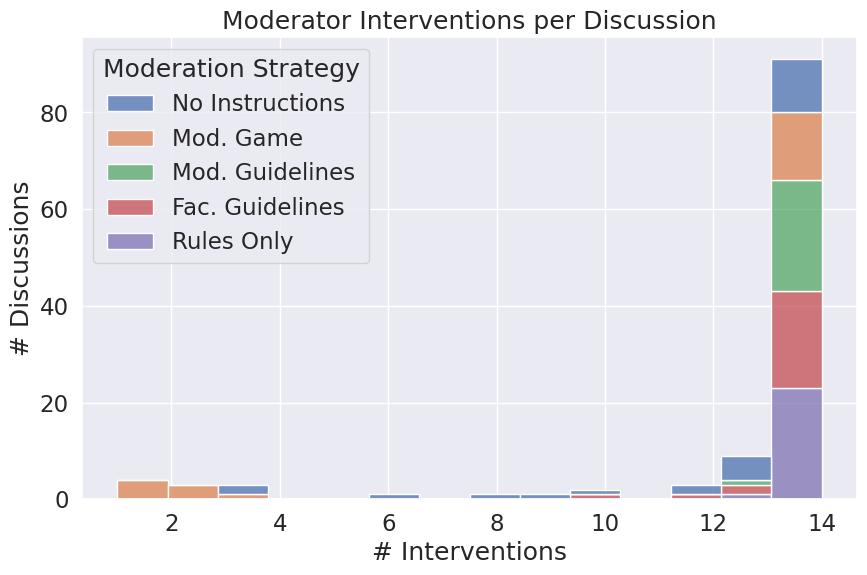

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=intervention_df.rename(
        {"conv_variant": "Moderation Strategy"}, axis=1
    ),
    x="moderator_interventions",
    hue="Moderation Strategy",
    multiple="stack",
    bins=14,
)
plt.xlabel("# Interventions")
plt.ylabel("# Discussions")
plt.title("Moderator Interventions per Discussion")

tasks.graphs.save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

## Statistical Analysis

In [7]:
analysis_df = full_df.loc[
    (full_df.intent != "Moderator") & (full_df.model != "hardcoded")
]

### Moderation Strategy

#### Toxicity

In [8]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Toxicity"
)

8.88378208253797e-199

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_stats.png


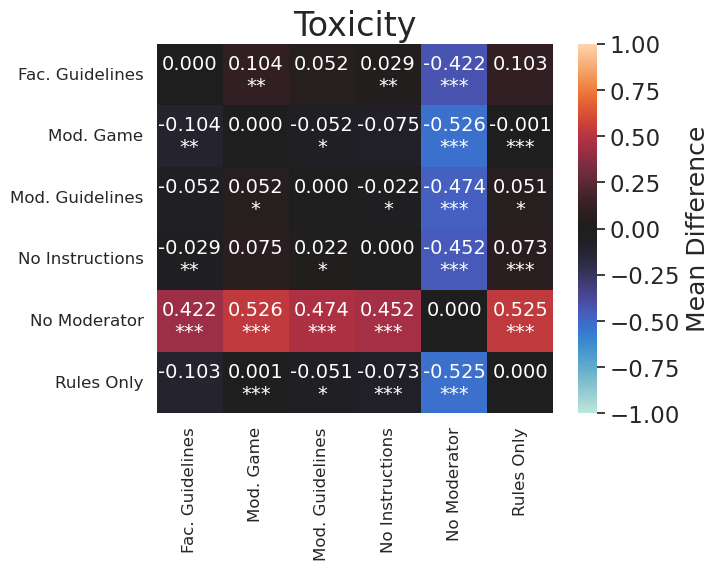

In [9]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Toxicity",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "toxicity_stats.png")
plt.show()

#### Argument Quality

In [10]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Argument Quality"
)

4.79135280857012e-46

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/argumentq_stats.png


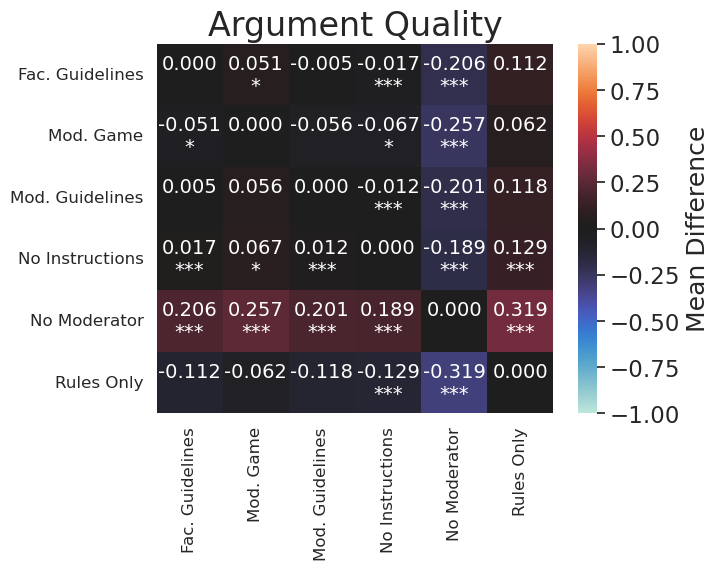

In [11]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Argument Quality",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "argumentq_stats.png")
plt.show()